In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

def calculate_mse(original_image, filtered_image):
    #Calculate the mse of the output image
    mse = np.mean((original_image - filtered_image) ** 2)
    return mse

def add_salt_and_pepper_noise(image, noise_level):
    noisy_image = image.copy()
    total_pixels = image.size

    # Salt noise
    num_salt = np.ceil(noise_level * total_pixels * 0.5).astype(int)

    for channel in range(image.shape[2]):
        #For every channel, determine different random sample of pixels and add noise for that channel
        salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
        noisy_image[salt_coords[0], salt_coords[1], channel] = 255  # White salt

    # Pepper noise
    num_pepper = np.ceil(noise_level * total_pixels * 0.5).astype(int)

    for channel in range(image.shape[2]):
        #For every channel, determine different random sample of pixels and add noise for that channel
        pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
        noisy_image[pepper_coords[0], pepper_coords[1], channel] = 0  # Black pepper

    return noisy_image

def add_salt_and_pepper_noise_correlated(image, noise_level):
    noisy_image = image.copy()
    total_pixels = image.size

    # Salt noise
    num_salt = np.ceil(noise_level * total_pixels * 0.5).astype(int)
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
    
    #Add noise to same pixels for every channel
    for channel in range(image.shape[2]):
        noisy_image[salt_coords[0], salt_coords[1], channel] = 255  # White salt

    # Pepper noise
    num_pepper = np.ceil(noise_level * total_pixels * 0.5).astype(int)
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
    
    #Add noise to same pixels for every channel
    for channel in range(image.shape[2]):
        noisy_image[pepper_coords[0], pepper_coords[1], channel] = 0  # Black pepper

    return noisy_image

# Marginal Strategy

In [2]:
def marginal(image, kernel_size):
    h, w, _ = image.shape
    result_image = image.copy()
    
    #for every pixel
    for row in range(h):
        for col in range(w):
            #consider each channel differently
            red = []
            green = []
            blue = []
            #add r, g and b values of the neighbors into list
            for i in range(max(0, row - (kernel_size // 2)), min(h, row + (kernel_size // 2)+ 1)):
                for j in range(max(0, col - (kernel_size // 2)), min(w, col + (kernel_size // 2)+ 1)):
                    red.append(image[i][j][0])
                    green.append(image[i][j][1])
                    blue.append(image[i][j][2])
                    
            #find the medians of each channel and assign to current pixel
            result_image[row][col][0] = np.median(red)
            result_image[row][col][1] = np.median(green)
            result_image[row][col][2] = np.median(blue)
    return result_image

# Vector Strategy - Lexicographical Ordering

In [3]:
def lexicographical(image, kernel_size):
    h, w, _ = image.shape
    result_image = image.copy()

    for row in range(h):
        for col in range(w):
            #get the color vectors of neighbors
            pixels = image[max(0, row - (kernel_size // 2)):min(h, row + (kernel_size // 2) + 1),
                           max(0, col - (kernel_size // 2)):min(w, col + (kernel_size // 2) + 1)].reshape(-1, 3)
            
            #sort the color vectors of neighors lexicographically and find the middle value and assing to current pixel
            result_image[row][col] = pixels[np.lexsort(pixels.T)][len(pixels) // 2]
    return result_image

# Vector Strategy - Bitmix Ordering

In [4]:
def bitmix(image, kernel_size):
    h, w, _ = image.shape
    result_image = image.copy()

    for row in range(h):
        for col in range(w):
            indexes = {}
            #get the color vectors of the neighbors
            pixels = image[max(0, row - (kernel_size // 2)):min(h, row + (kernel_size // 2) + 1),
                           max(0, col - (kernel_size // 2)):min(w, col + (kernel_size // 2) + 1)].reshape(-1, 3)

            
            #calculate bitmix integers of each color vector in pixels
            for i in range(len(pixels)):
                r, g, b = format(pixels[i][0],'08b'), format(pixels[i][1],'08b'), format(pixels[i][2],'08b')
                indexes[i] = ''.join([r[i] + g[i] + b[i] for i in range(8)])
                
            #sort the bitmix values of neighors and find the middle value and assing to current pixel
            sorted_items = sorted(indexes.items(), key=lambda x: x[1])
            result_image[row][col] = pixels[sorted_items[len(pixels) // 2][0]]
    return result_image

# Vector Strategy - Norm Based Ordering

In [5]:
def norm_based(image, kernel_size):
    h, w, _ = image.shape
    result_image = image.copy()

    for row in range(h):
        for col in range(w):
            indexes = {}
             #get the color vectors of the neighbors
            pixels = image[max(0, row - (kernel_size // 2)):min(h, row + (kernel_size // 2) + 1),
                           max(0, col - (kernel_size // 2)):min(w, col + (kernel_size // 2) + 1)].reshape(-1, 3)

            #calculate norms of each color vector in pixels        
            for i in range(len(pixels)):
                norm = math.sqrt(pixels[i][0]**2 + pixels[i][1]**2 + pixels[i][2]**2)
                indexes[i] = norm
                
            #sort the color vectors by norm values of neighors and find the middle value and assing to current pixel
            sorted_items = sorted(indexes.items(), key=lambda x: x[1])
            result_image[row][col] = pixels[sorted_items[len(pixels) // 2][0]]
    return result_image

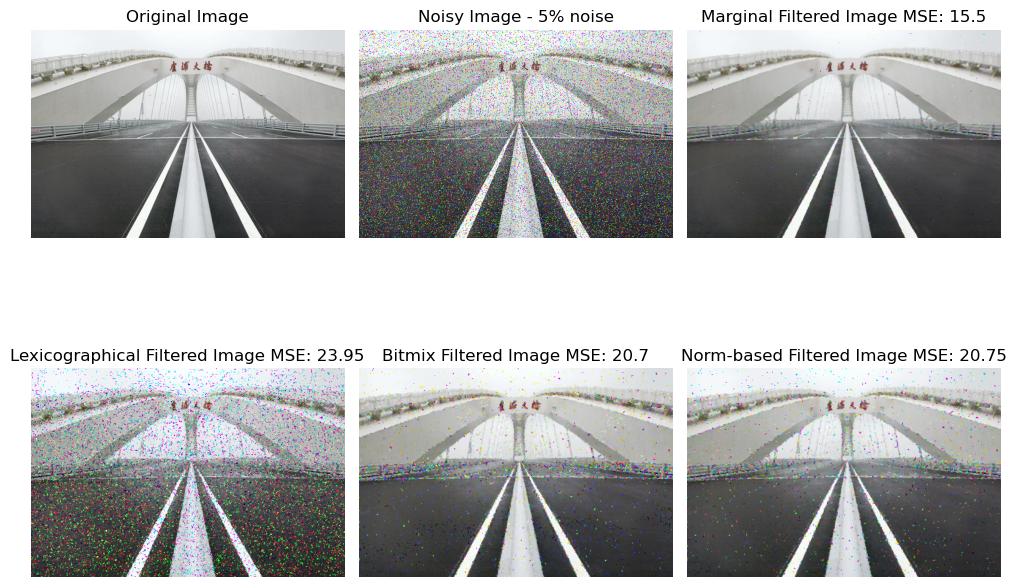

In [17]:
original_image = cv2.cvtColor(cv2.imread('sample/0.png'), cv2.COLOR_BGR2RGB)
noisy_image = add_salt_and_pepper_noise(original_image, 0.05)
marginal_filtered_image = marginal(noisy_image, 3)
lexicographical_filtered_image = lexicographical(noisy_image, 3)
bitmix_filtered_image = bitmix(noisy_image, 3)
norm_based_filtered_image = norm_based(noisy_image, 3)
plt.figure(figsize=(10, 8))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Noisy Image
plt.subplot(2, 3, 2)
plt.imshow(noisy_image)
plt.title('Noisy Image - 5% noise')
plt.axis('off')

# Marginal Filtered Image
plt.subplot(2, 3, 3)
plt.imshow(marginal_filtered_image)
plt.title('Marginal Filtered Image MSE: '+str(round(calculate_mse(original_image, marginal_filtered_image), 2)))
plt.axis('off')

# Lexicographical Filtered Image
plt.subplot(2, 3, 4)
plt.imshow(lexicographical_filtered_image)
plt.title('Lexicographical Filtered Image MSE: '+str(round(calculate_mse(original_image, lexicographical_filtered_image), 2)))
plt.axis('off')

# Bitmix Filtered Image
plt.subplot(2, 3, 5)
plt.imshow(bitmix_filtered_image)
plt.title('Bitmix Filtered Image MSE: '+str(round(calculate_mse(original_image, bitmix_filtered_image), 2)))
plt.axis('off')

# Norm-based Filtered Image
plt.subplot(2, 3, 6)
plt.imshow(norm_based_filtered_image)
plt.title('Norm-based Filtered Image MSE: '+str(round(calculate_mse(original_image, norm_based_filtered_image), 2)))
plt.axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

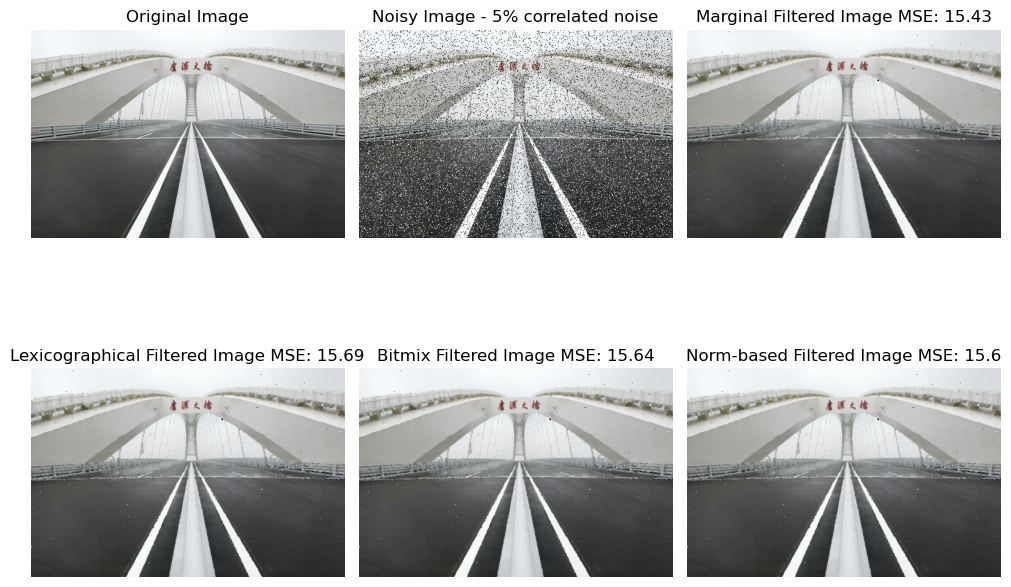

In [20]:
original_image = cv2.cvtColor(cv2.imread('sample/0.png'), cv2.COLOR_BGR2RGB)
noisy_image = add_salt_and_pepper_noise_correlated(original_image, 0.05)
marginal_filtered_image = marginal(noisy_image, 3)
lexicographical_filtered_image = lexicographical(noisy_image, 3)
bitmix_filtered_image = bitmix(noisy_image, 3)
norm_based_filtered_image = norm_based(noisy_image, 3)
plt.figure(figsize=(10, 8))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Noisy Image
plt.subplot(2, 3, 2)
plt.imshow(noisy_image)
plt.title('Noisy Image - 5% correlated noise')
plt.axis('off')

# Marginal Filtered Image
plt.subplot(2, 3, 3)
plt.imshow(marginal_filtered_image)
plt.title('Marginal Filtered Image MSE: '+str(round(calculate_mse(original_image, marginal_filtered_image), 2)))
plt.axis('off')

# Lexicographical Filtered Image
plt.subplot(2, 3, 4)
plt.imshow(lexicographical_filtered_image)
plt.title('Lexicographical Filtered Image MSE: '+str(round(calculate_mse(original_image, lexicographical_filtered_image), 2)))
plt.axis('off')

# Bitmix Filtered Image
plt.subplot(2, 3, 5)
plt.imshow(bitmix_filtered_image)
plt.title('Bitmix Filtered Image MSE: '+str(round(calculate_mse(original_image, bitmix_filtered_image), 2)))
plt.axis('off')

# Norm-based Filtered Image
plt.subplot(2, 3, 6)
plt.imshow(norm_based_filtered_image)
plt.title('Norm-based Filtered Image MSE: '+str(round(calculate_mse(original_image, norm_based_filtered_image), 2)))
plt.axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Tests

In [6]:
noise_rates = [0.01, 0.05, 0.3]
filter_sizes = [3, 7, 15]
results = pd.DataFrame(columns=["strategy", "sample", "noise", "filter_size", "mse"])

for noise in noise_rates:
    for filter_size in filter_sizes:
        for i in range(10):
            original_image = cv2.cvtColor(cv2.imread('sample/'+str(i)+'.png'), cv2.COLOR_BGR2RGB)
            noisy_image = add_salt_and_pepper_noise(original_image, noise)
            
            filtered_image = marginal(noisy_image, filter_size)
            mse = calculate_mse(original_image, filtered_image)
            print('Sample '+str(i)+' for Marginal Strategy - noise: '+str(noise)+' filter size: '+str(filter_size)+' MSE: '+ str(round(mse, 2)))
            results.loc[len(results.index)] = ['marginal', i, noise, filter_size, mse]  
            
            filtered_image = lexicographical(noisy_image, filter_size)
            mse = calculate_mse(original_image, filtered_image)
            print('Sample '+str(i)+' for Vector Strategy(Lexicographical Ordering) - noise: '+str(noise)+' filter size: '+str(filter_size)+' MSE: '+ str(round(mse, 2)))
            results.loc[len(results.index)] = ['lexicographical', i, noise, filter_size, mse]   
            
            filtered_image = bitmix(noisy_image, filter_size)
            mse = calculate_mse(original_image, filtered_image)
            print('Sample '+str(i)+' for Vector Strategy(Bitmix Ordering) - noise: '+str(noise)+' filter size: '+str(filter_size)+' MSE: '+ str(round(mse, 2)))
            results.loc[len(results.index)] = ['bitmix', i, noise, filter_size, mse]   
            
            filtered_image = norm_based(noisy_image, filter_size)
            mse = calculate_mse(original_image, filtered_image)
            print('Sample '+str(i)+' for Vector Strategy(Norm Based Ordering) - noise: '+str(noise)+' filter size: '+str(filter_size)+' MSE: '+ str(round(mse, 2)))
            results.loc[len(results.index)] = ['norm_based', i, noise, filter_size, mse]   
                    

Sample 0 for Marginal Strategy - noise: 0.01 filter size: 3 MSE: 13.63
Sample 0 for Vector Strategy(Lexicographical Ordering) - noise: 0.01 filter size: 3 MSE: 15.63
Sample 0 for Vector Strategy(Bitmix Ordering) - noise: 0.01 filter size: 3 MSE: 14.76
Sample 0 for Vector Strategy(Norm Based Ordering) - noise: 0.01 filter size: 3 MSE: 14.77
Sample 1 for Marginal Strategy - noise: 0.01 filter size: 3 MSE: 18.11
Sample 1 for Vector Strategy(Lexicographical Ordering) - noise: 0.01 filter size: 3 MSE: 21.59
Sample 1 for Vector Strategy(Bitmix Ordering) - noise: 0.01 filter size: 3 MSE: 21.11
Sample 1 for Vector Strategy(Norm Based Ordering) - noise: 0.01 filter size: 3 MSE: 20.81
Sample 2 for Marginal Strategy - noise: 0.01 filter size: 3 MSE: 7.01
Sample 2 for Vector Strategy(Lexicographical Ordering) - noise: 0.01 filter size: 3 MSE: 10.36
Sample 2 for Vector Strategy(Bitmix Ordering) - noise: 0.01 filter size: 3 MSE: 8.24
Sample 2 for Vector Strategy(Norm Based Ordering) - noise: 0.01 fi

Sample 4 for Marginal Strategy - noise: 0.01 filter size: 15 MSE: 19.53
Sample 4 for Vector Strategy(Lexicographical Ordering) - noise: 0.01 filter size: 15 MSE: 23.23
Sample 4 for Vector Strategy(Bitmix Ordering) - noise: 0.01 filter size: 15 MSE: 21.59
Sample 4 for Vector Strategy(Norm Based Ordering) - noise: 0.01 filter size: 15 MSE: 21.4
Sample 5 for Marginal Strategy - noise: 0.01 filter size: 15 MSE: 21.85
Sample 5 for Vector Strategy(Lexicographical Ordering) - noise: 0.01 filter size: 15 MSE: 30.03
Sample 5 for Vector Strategy(Bitmix Ordering) - noise: 0.01 filter size: 15 MSE: 25.25
Sample 5 for Vector Strategy(Norm Based Ordering) - noise: 0.01 filter size: 15 MSE: 24.56
Sample 6 for Marginal Strategy - noise: 0.01 filter size: 15 MSE: 16.42
Sample 6 for Vector Strategy(Lexicographical Ordering) - noise: 0.01 filter size: 15 MSE: 19.04
Sample 6 for Vector Strategy(Bitmix Ordering) - noise: 0.01 filter size: 15 MSE: 17.83
Sample 6 for Vector Strategy(Norm Based Ordering) - no

Sample 8 for Marginal Strategy - noise: 0.05 filter size: 7 MSE: 43.64
Sample 8 for Vector Strategy(Lexicographical Ordering) - noise: 0.05 filter size: 7 MSE: 51.22
Sample 8 for Vector Strategy(Bitmix Ordering) - noise: 0.05 filter size: 7 MSE: 49.37
Sample 8 for Vector Strategy(Norm Based Ordering) - noise: 0.05 filter size: 7 MSE: 48.86
Sample 9 for Marginal Strategy - noise: 0.05 filter size: 7 MSE: 23.08
Sample 9 for Vector Strategy(Lexicographical Ordering) - noise: 0.05 filter size: 7 MSE: 34.38
Sample 9 for Vector Strategy(Bitmix Ordering) - noise: 0.05 filter size: 7 MSE: 32.04
Sample 9 for Vector Strategy(Norm Based Ordering) - noise: 0.05 filter size: 7 MSE: 30.23
Sample 0 for Marginal Strategy - noise: 0.05 filter size: 15 MSE: 27.69
Sample 0 for Vector Strategy(Lexicographical Ordering) - noise: 0.05 filter size: 15 MSE: 35.98
Sample 0 for Vector Strategy(Bitmix Ordering) - noise: 0.05 filter size: 15 MSE: 33.36
Sample 0 for Vector Strategy(Norm Based Ordering) - noise: 0.

Sample 2 for Vector Strategy(Lexicographical Ordering) - noise: 0.3 filter size: 7 MSE: 55.18
Sample 2 for Vector Strategy(Bitmix Ordering) - noise: 0.3 filter size: 7 MSE: 57.38
Sample 2 for Vector Strategy(Norm Based Ordering) - noise: 0.3 filter size: 7 MSE: 79.51
Sample 3 for Marginal Strategy - noise: 0.3 filter size: 7 MSE: 52.79
Sample 3 for Vector Strategy(Lexicographical Ordering) - noise: 0.3 filter size: 7 MSE: 75.02
Sample 3 for Vector Strategy(Bitmix Ordering) - noise: 0.3 filter size: 7 MSE: 88.28
Sample 3 for Vector Strategy(Norm Based Ordering) - noise: 0.3 filter size: 7 MSE: 92.25
Sample 4 for Marginal Strategy - noise: 0.3 filter size: 7 MSE: 21.79
Sample 4 for Vector Strategy(Lexicographical Ordering) - noise: 0.3 filter size: 7 MSE: 54.06
Sample 4 for Vector Strategy(Bitmix Ordering) - noise: 0.3 filter size: 7 MSE: 71.64
Sample 4 for Vector Strategy(Norm Based Ordering) - noise: 0.3 filter size: 7 MSE: 75.09
Sample 5 for Marginal Strategy - noise: 0.3 filter size:

In [7]:
results.to_csv("results.csv")

In [8]:
results = pd.read_csv("results.csv").drop(columns="Unnamed: 0")
results

,strategy,sample,noise,filter_size,mse
0,marginal,0,0.01,3,13.627131
1,lexicographical,0,0.01,3,15.626550
2,bitmix,0,0.01,3,14.759468
3,norm_based,0,0.01,3,14.767662
4,marginal,1,0.01,3,18.112652
...,...,...,...,...,...
355,norm_based,8,0.30,15,102.973345
356,marginal,9,0.30,15,44.357048
357,lexicographical,9,0.30,15,64.461739
358,bitmix,9,0.30,15,75.887543


In [9]:
#Overall Performance - Mean MSE values for all test cases
results.groupby("strategy")["mse"].mean().sort_values()

strategy
marginal           27.654096
lexicographical    40.994409
bitmix             42.866167
norm_based         45.055061
Name: mse, dtype: float64

In [10]:
#Sample Performance - Mean MSE values for all test cases of Samples
a = results.groupby(["strategy", "sample"])["mse"].mean().reset_index().sort_values(["sample", "mse"])
a

,strategy,sample,mse
20,marginal,0,26.344426
10,lexicographical,0,39.316905
0,bitmix,0,42.301921
30,norm_based,0,43.045647
21,marginal,1,35.435099
11,lexicographical,1,48.010899
1,bitmix,1,51.272279
31,norm_based,1,51.569184
22,marginal,2,15.833603
2,bitmix,2,29.844608


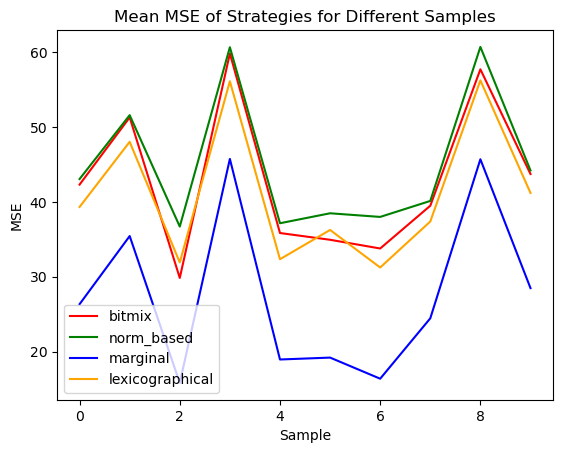

In [11]:
color_map = {'marginal': 'blue', 'norm_based': 'green', 'bitmix': 'red', 'lexicographical': 'orange'}

# Iterate over unique strategies and plot the corresponding data
for strategy in set(a['strategy']):
    strategy_data = a[a['strategy'] == strategy]
    plt.plot(strategy_data['sample'], strategy_data['mse'], label=strategy, color=color_map[strategy])

# Set labels and title
plt.xlabel('Sample')
plt.ylabel('MSE')
plt.title('Mean MSE of Strategies for Different Samples')
plt.legend()

# Show the plot
plt.show()

In [12]:
#Noise Performance - Mean MSE values for all test cases of Noises
b = results.groupby(["strategy", "noise"])["mse"].mean().reset_index().sort_values(["noise", "mse"])
b

,strategy,noise,mse
6,marginal,0.01,22.716477
9,norm_based,0.01,24.615241
0,bitmix,0.01,25.005193
3,lexicographical,0.01,26.608619
7,marginal,0.05,23.453995
10,norm_based,0.05,28.607609
1,bitmix,0.05,29.229365
4,lexicographical,0.05,32.732588
8,marginal,0.30,36.791815
5,lexicographical,0.30,63.642021


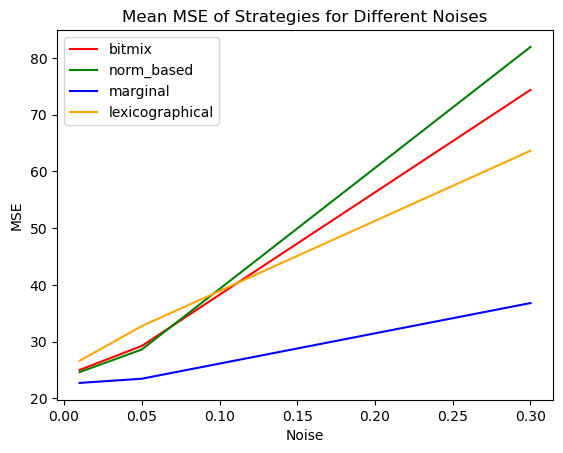

In [18]:
color_map = {'marginal': 'blue', 'norm_based': 'green', 'bitmix': 'red', 'lexicographical': 'orange'}

# Iterate over unique strategies and plot the corresponding data
for strategy in set(b['strategy']):
    strategy_data = b[b['strategy'] == strategy]
    plt.plot(strategy_data['noise'], strategy_data['mse'], label=strategy, color=color_map[strategy])

# Set labels and title
plt.xlabel('Noise')
plt.ylabel('MSE')
plt.title('Mean MSE of Strategies for Different Noises')
plt.legend()

# Show the plot
plt.show()

In [14]:
#Filter Size Performance - Mean MSE values for all test cases of filter sizes
c = results.groupby(["strategy", "filter_size"])["mse"].mean().reset_index().sort_values(["filter_size", "mse"]).reset_index(drop=True)
c

,strategy,filter_size,mse
0,marginal,3,23.667891
1,lexicographical,3,34.910528
2,bitmix,3,35.191553
3,norm_based,3,35.510570
4,marginal,7,26.437869
5,lexicographical,7,40.987010
6,bitmix,7,42.955077
7,norm_based,7,45.067354
8,marginal,15,32.856526
9,lexicographical,15,47.085689


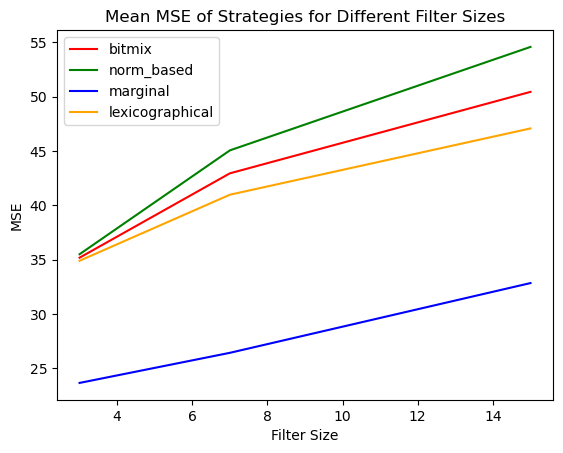

In [19]:
color_map = {'marginal': 'blue', 'norm_based': 'green', 'bitmix': 'red', 'lexicographical': 'orange'}

# Iterate over unique strategies and plot the corresponding data
for strategy in set(c['strategy']):
    strategy_data = c[c['strategy'] == strategy]
    plt.plot(strategy_data['filter_size'], strategy_data['mse'], label=strategy, color=color_map[strategy])

# Set labels and title
plt.xlabel('Filter Size')
plt.ylabel('MSE')
plt.title('Mean MSE of Strategies for Different Filter Sizes')
plt.legend()

# Show the plot
plt.show()